In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner as kt

### Load dataframe

In [2]:
main_data = pd.read_csv("data_labels_mainData.csv")
extra_data = pd.read_csv("data_labels_extraData.csv")

### split data into different folders for different cell types

In [3]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in main_data.iterrows():
    image_name = row["ImageName"]
    cell_name = row["cellTypeName"]
    is_cancer = str(row["isCancerous"])

    new_folder_multi = os.path.join(root, cell_name)
    new_folder_bin = os.path.join(root, is_cancer)

    os.makedirs(new_folder_multi, exist_ok=True)
    #os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

    dest_multi = os.path.join(root, cell_name)
    #dest_bin = os.path.join(root, is_cancer)

    go = shutil.copy(source,dest_multi)
    #go = shutil.copy(source, dest_bin)

### Add training data for cancerous classification from extra dataset 

In [5]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in extra_data.iterrows():
    image_name = row["ImageName"]
    is_cancer = str(row["isCancerous"])

    new_folder_bin = os.path.join(root, is_cancer)

    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

    dest_bin = os.path.join(root, is_cancer)

    go = shutil.copy(source, dest_bin)

### Old load image code 

In [4]:
def get_images(img_list, path):    
    images = list()
    
    for img in img_list:
        img = cv2.imread(os.path.join(path, img))
        # resize to 0-1 for faster computation
        resized = img / 255
        images.append(resized)
        
    return images

images, cell_type, is_cancerous = get_images(main_data["ImageName"], "patch_images"), main_data[["cellType"]], main_data[["isCancerous"]]

print(len(images))
#print(images[0].shape)
print(len(cell_type))
print(len(is_cancerous))

9896
9896
9896


### Get data from splitted folder

In [4]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

def cancerous_classify_data():    
    images = list()
    labels = list()
    
    for label in [0, 1]:
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(label)
        
    return (images, labels)


### Base CNN model

In [8]:
images, cancer_label = cancerous_classify_data()

# try testing cancerous dataset
# x_train, x_test, y_train, y_test = train_test_split(
#     np.array(images), np.array(is_cancerous), test_size=0.2
# )

x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(cancer_label), test_size=0.2
)

def get_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model

print(x_train.shape)
print(y_train.shape)
model = get_model()

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
prediction = model.predict(x_test)

(16224, 27, 27, 3)
(16224,)
Metal device set to: Apple M1 Pro


2022-05-03 12:26:41.281955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 12:26:41.282248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2022-05-03 12:26:41.520725: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 12:26:41.725192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


501/507 [============================>.] - ETA: 0s - loss: 0.4109 - accuracy: 0.8076 - auc: 0.8794

2022-05-03 12:26:46.169622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.4095 - accuracy: 0.8084 - auc: 0.8804 - val_loss: 0.3615 - val_accuracy: 0.8397 - val_auc: 0.9163
Epoch 2/10
507/507 [==============================] - 5s 9ms/step - loss: 0.3372 - accuracy: 0.8529 - auc: 0.9212 - val_loss: 0.3632 - val_accuracy: 0.8390 - val_auc: 0.9265
Epoch 3/10
507/507 [==============================] - 5s 9ms/step - loss: 0.3206 - accuracy: 0.8630 - auc: 0.9291 - val_loss: 0.3173 - val_accuracy: 0.8602 - val_auc: 0.9313
Epoch 4/10
507/507 [==============================] - 5s 9ms/step - loss: 0.3136 - accuracy: 0.8664 - auc: 0.9321 - val_loss: 0.3372 - val_accuracy: 0.8452 - val_auc: 0.9355
Epoch 5/10
507/507 [==============================] - 5s 9ms/step - loss: 0.2941 - accuracy: 0.8749 - auc: 0.9406 - val_loss: 0.3164 - val_accuracy: 0.8587 - val_auc: 0.9337
Epoch 6/10
507/507 [==============================] - 5s 9ms/step - loss: 0.2890 - accuracy: 0.8764 - auc: 0.9423 - val_loss: 0.3069 - val_a

2022-05-03 12:27:29.655092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Tune CNN model

Tunable parameters:
- Size of kernel of Convolution/Pooling Layers
- Strides of Convolution/Pooling Layers
- Activation function

In [47]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(cancer_label), test_size=0.2
)

def cnn_tuner(hp):
    model = tf.keras.Sequential()

    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(hp.Int(f'convo_filter', 16, 128, step=16), (3, 3), activation=hp.Choice("activation_convo", ["relu", "sigmoid", "softmax", "tanh"]), input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
        
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    # hidden layers
    for i in range(hp.Int('layers_no', 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Int('hidden_layer', 32, 256, step=32), activation=hp.Choice(f"activation_hidden_{i}", ["relu", "sigmoid", "softmax", "tanh"])))
        
    # output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))   
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model

# status.expect_partial()
              
tuner = kt.RandomSearch(cnn_tuner, objective="val_accuracy", max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 32s]
val_accuracy: 0.8639053106307983

Best val_accuracy So Far: 0.8639053106307983
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit


In [52]:
print(f"Best Convolution filter: {tuner.get_best_hyperparameters()[0].get('convo_filter')}")
print(f"Best number of hidden layer: {tuner.get_best_hyperparameters()[0].get('hidden_layer')}")
for i in range(tuner.get_best_hyperparameters()[0].get('layers_no')):
    print(f"Best nodes in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get('hidden_layer')}")
    print(f"Best activation in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_hidden_{i}')}")
    


Best Convolution filter: 96
Best number of hidden layer: 160
Best nodes in hidden layer 0: 160
Best activation in hidden layer 0: sigmoid
Best nodes in hidden layer 1: 160
Best activation in hidden layer 1: tanh
Best nodes in hidden layer 2: 160
Best activation in hidden layer 2: sigmoid
Best nodes in hidden layer 3: 160
Best activation in hidden layer 3: relu


In [48]:
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2022-05-03 13:15:50.902990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


505/507 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8665 - auc: 0.9364

2022-05-03 13:15:56.659471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 7s 13ms/step - loss: 0.3041 - accuracy: 0.8667 - auc: 0.9364 - val_loss: 0.3408 - val_accuracy: 0.8474 - val_auc: 0.9363
Epoch 2/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2892 - accuracy: 0.8739 - auc: 0.9425 - val_loss: 0.3483 - val_accuracy: 0.8614 - val_auc: 0.9390
Epoch 3/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2661 - accuracy: 0.8876 - auc: 0.9514 - val_loss: 0.3096 - val_accuracy: 0.8728 - val_auc: 0.9376
Epoch 4/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2448 - accuracy: 0.8935 - auc: 0.9590 - val_loss: 0.4050 - val_accuracy: 0.8425 - val_auc: 0.9346
Epoch 5/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2220 - accuracy: 0.9077 - auc: 0.9662 - val_loss: 0.3574 - val_accuracy: 0.8627 - val_auc: 0.9325
Epoch 6/10
507/507 [==============================] - 6s 12ms/step - loss: 0.1984 - accuracy: 0.9173 - auc: 0.9731 - val_loss: 0.3761 - 

### Ensemble model

In [12]:
# generate train and test set
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(cancer_label), test_size=0.2)

# intialize and train sub-models
def get_sub_model():
    # number of sub models
    nets = 5
    sub_models = [0]*nets
    
    for i in range(nets):
        model = get_model()
        # fit sub_model with train and test data
        model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
        
        # save fitted sub_model to model list
        sub_models[i] = model
        
    return sub_models
    
sub_models = get_sub_model()

Epoch 1/5


2022-05-03 12:29:02.441814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


502/507 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8150 - auc: 0.8832

2022-05-03 12:29:07.267409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 6s 11ms/step - loss: 0.4023 - accuracy: 0.8155 - auc: 0.8839 - val_loss: 0.3566 - val_accuracy: 0.8481 - val_auc: 0.9196
Epoch 2/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3472 - accuracy: 0.8513 - auc: 0.9155 - val_loss: 0.4497 - val_accuracy: 0.7894 - val_auc: 0.9224
Epoch 3/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3271 - accuracy: 0.8634 - auc: 0.9255 - val_loss: 0.3253 - val_accuracy: 0.8609 - val_auc: 0.9320
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3061 - accuracy: 0.8726 - auc: 0.9345 - val_loss: 0.3085 - val_accuracy: 0.8688 - val_auc: 0.9371
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.2996 - accuracy: 0.8755 - auc: 0.9376 - val_loss: 0.3480 - val_accuracy: 0.8543 - val_auc: 0.9352
Epoch 1/5
  1/507 [..............................] - ETA: 2:36 - loss: 0.6759 - accuracy: 0.5938 - auc: 0.6053

2022-05-03 12:29:27.537301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


506/507 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8018 - auc: 0.8733

2022-05-03 12:29:31.934386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.4183 - accuracy: 0.8020 - auc: 0.8736 - val_loss: 0.3767 - val_accuracy: 0.8323 - val_auc: 0.9160
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3408 - accuracy: 0.8543 - auc: 0.9189 - val_loss: 0.3306 - val_accuracy: 0.8590 - val_auc: 0.9262
Epoch 3/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3263 - accuracy: 0.8611 - auc: 0.9258 - val_loss: 0.3197 - val_accuracy: 0.8664 - val_auc: 0.9308
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3099 - accuracy: 0.8705 - auc: 0.9332 - val_loss: 0.3471 - val_accuracy: 0.8531 - val_auc: 0.9297
Epoch 5/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3007 - accuracy: 0.8736 - auc: 0.9373 - val_loss: 0.3209 - val_accuracy: 0.8632 - val_auc: 0.9362
Epoch 1/5
  1/507 [..............................] - ETA: 2:38 - loss: 0.6501 - accuracy: 0.7188 - auc: 0.6473

2022-05-03 12:29:52.092467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8187 - auc: 0.8893

2022-05-03 12:29:56.532275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.3943 - accuracy: 0.8187 - auc: 0.8893 - val_loss: 0.3908 - val_accuracy: 0.8222 - val_auc: 0.9181
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3409 - accuracy: 0.8515 - auc: 0.9188 - val_loss: 0.3395 - val_accuracy: 0.8540 - val_auc: 0.9244
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3256 - accuracy: 0.8600 - auc: 0.9261 - val_loss: 0.3995 - val_accuracy: 0.8257 - val_auc: 0.9281
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3121 - accuracy: 0.8705 - auc: 0.9322 - val_loss: 0.4551 - val_accuracy: 0.7944 - val_auc: 0.9304
Epoch 5/5
507/507 [==============================] - 5s 9ms/step - loss: 0.2986 - accuracy: 0.8746 - auc: 0.9381 - val_loss: 0.3361 - val_accuracy: 0.8543 - val_auc: 0.9338
Epoch 1/5
  1/507 [..............................] - ETA: 2:36 - loss: 0.6376 - accuracy: 0.7812 - auc: 0.6771

2022-05-03 12:30:16.958711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


506/507 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8136 - auc: 0.8789

2022-05-03 12:30:21.261002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.4106 - accuracy: 0.8138 - auc: 0.8789 - val_loss: 0.3663 - val_accuracy: 0.8432 - val_auc: 0.9141
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3464 - accuracy: 0.8497 - auc: 0.9162 - val_loss: 0.3438 - val_accuracy: 0.8531 - val_auc: 0.9204
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3312 - accuracy: 0.8572 - auc: 0.9237 - val_loss: 0.4029 - val_accuracy: 0.8129 - val_auc: 0.9269
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3136 - accuracy: 0.8658 - auc: 0.9317 - val_loss: 0.3340 - val_accuracy: 0.8484 - val_auc: 0.9341
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3033 - accuracy: 0.8715 - auc: 0.9362 - val_loss: 0.3656 - val_accuracy: 0.8452 - val_auc: 0.9314
Epoch 1/5
  1/507 [..............................] - ETA: 2:51 - loss: 0.6469 - accuracy: 0.7500 - auc: 0.5990

2022-05-03 12:30:41.839497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


502/507 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8134 - auc: 0.8805

2022-05-03 12:30:46.377667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 6s 10ms/step - loss: 0.4075 - accuracy: 0.8141 - auc: 0.8808 - val_loss: 0.3662 - val_accuracy: 0.8390 - val_auc: 0.9201
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3458 - accuracy: 0.8499 - auc: 0.9162 - val_loss: 0.3440 - val_accuracy: 0.8523 - val_auc: 0.9224
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3267 - accuracy: 0.8606 - auc: 0.9255 - val_loss: 0.3220 - val_accuracy: 0.8644 - val_auc: 0.9308
Epoch 4/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3026 - accuracy: 0.8702 - auc: 0.9363 - val_loss: 0.3158 - val_accuracy: 0.8698 - val_auc: 0.9339
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.2974 - accuracy: 0.8759 - auc: 0.9384 - val_loss: 0.3303 - val_accuracy: 0.8656 - val_auc: 0.9305


In [13]:
# method to get output from submodels to feed meta_learner
# shape of dataset would be (no rows of OG dataset, [no output of sub model * no sub model])
def get_ensembled_x(x):
    ensembled_data = None
    for sub_model in sub_models:
        prediction = sub_model.predict(x)
        
        # stack prediction of sub model to ensembled data
        if ensembled_data is None:
            ensembled_data = prediction
        else:
            ensembled_data = np.dstack((ensembled_data, prediction))
            
    # ensemble data initially shape iz (no_col, no submodels, no classes)        
    # reshape to (no_col, no submodels*no classes)
    ensembled_data = ensembled_data.reshape(ensembled_data.shape[0], ensembled_data.shape[1]*ensembled_data.shape[2])
    return ensembled_data

def get_meta_learner():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="tanh"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    # get train ensembled data
    ensembled_x = get_ensembled_x(x_train)
    
    model.fit(ensembled_x, y_train, epochs=10)
    return model 

In [14]:
# evaluate with ensembled CNN model
# get test data
ensembled_x_test = get_ensembled_x(x_test)
# get trained ensemble model
ensembled_model = get_meta_learner()
# evaluate
ensembled_model.evaluate(ensembled_x_test, y_test)

2022-05-03 12:31:14.316182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:14.592216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:14.857777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.125754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.393551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.748085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:16.835260: I tensorflow/core/grappler/optimizers/cust

Epoch 1/10


2022-05-03 12:31:20.944978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 4s 8ms/step - loss: 0.3601 - accuracy: 0.8763 - auc: 0.9177
Epoch 2/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2748 - accuracy: 0.8889 - auc: 0.9486
Epoch 3/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2718 - accuracy: 0.8903 - auc: 0.9498
Epoch 4/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2711 - accuracy: 0.8901 - auc: 0.9496
Epoch 5/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2700 - accuracy: 0.8904 - auc: 0.9500
Epoch 6/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2694 - accuracy: 0.8897 - auc: 0.9499
Epoch 7/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2690 - accuracy: 0.8907 - auc: 0.9501
Epoch 8/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2687 - accuracy: 0.8896 - auc: 0.9502
Epoch 9/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2685 - accuracy: 0.8895

2022-05-03 12:31:59.237369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


127/127 [==============================] - 1s 7ms/step - loss: 0.3076 - accuracy: 0.8691 - auc: 0.9365


[0.3075993061065674, 0.8690828680992126, 0.936511218547821]

### Base model for multiclass  

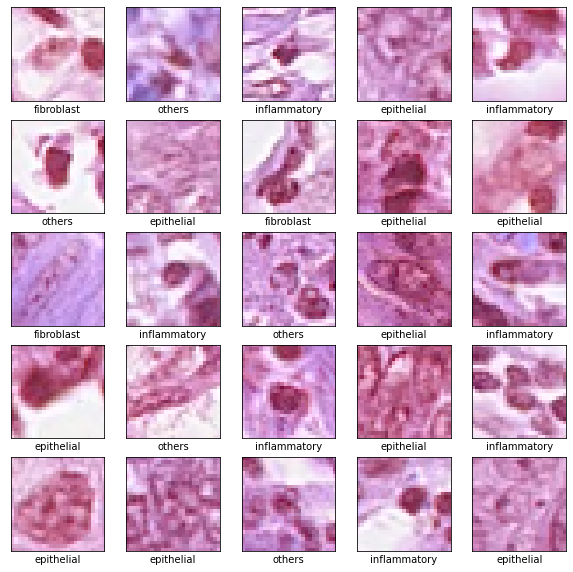

Epoch 1/100


2022-05-04 20:26:52.608137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.5982

2022-05-04 20:26:55.322814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 3s 11ms/step - loss: 0.9752 - accuracy: 0.5982 - val_loss: 0.7885 - val_accuracy: 0.6712
Epoch 2/100
248/248 [==============================] - 2s 9ms/step - loss: 0.7826 - accuracy: 0.6875 - val_loss: 0.7045 - val_accuracy: 0.7121
Epoch 3/100
248/248 [==============================] - 2s 9ms/step - loss: 0.7429 - accuracy: 0.7103 - val_loss: 0.6948 - val_accuracy: 0.7187
Epoch 4/100
248/248 [==============================] - 2s 9ms/step - loss: 0.7169 - accuracy: 0.7169 - val_loss: 0.6847 - val_accuracy: 0.7258
Epoch 5/100
248/248 [==============================] - 2s 9ms/step - loss: 0.6768 - accuracy: 0.7404 - val_loss: 0.7050 - val_accuracy: 0.7192
Epoch 6/100
248/248 [==============================] - 2s 9ms/step - loss: 0.6673 - accuracy: 0.7390 - val_loss: 0.6238 - val_accuracy: 0.7434
Epoch 7/100
248/248 [==============================] - 2s 9ms/step - loss: 0.6217 - accuracy: 0.7624 - val_loss: 0.6508 - val_accuracy: 0.7394
Epoch 8/10

Epoch 58/100
248/248 [==============================] - 2s 9ms/step - loss: 5.4748e-04 - accuracy: 0.9999 - val_loss: 2.5232 - val_accuracy: 0.7303
Epoch 59/100
248/248 [==============================] - 2s 9ms/step - loss: 3.7109e-04 - accuracy: 0.9997 - val_loss: 2.6493 - val_accuracy: 0.7318
Epoch 60/100
248/248 [==============================] - 2s 9ms/step - loss: 3.3829e-04 - accuracy: 0.9999 - val_loss: 2.7419 - val_accuracy: 0.7288
Epoch 61/100
248/248 [==============================] - 2s 9ms/step - loss: 3.4178e-04 - accuracy: 0.9997 - val_loss: 2.8117 - val_accuracy: 0.7298
Epoch 62/100
248/248 [==============================] - 2s 10ms/step - loss: 4.0001e-04 - accuracy: 0.9999 - val_loss: 2.8373 - val_accuracy: 0.7318
Epoch 63/100
248/248 [==============================] - 2s 10ms/step - loss: 4.7999e-04 - accuracy: 0.9999 - val_loss: 2.8478 - val_accuracy: 0.7258
Epoch 64/100
248/248 [==============================] - 2s 9ms/step - loss: 2.9899e-04 - accuracy: 0.9997 - va

2022-05-04 20:30:47.100784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
import matplotlib.pyplot as plt
all_class = ["epithelial", "fibroblast", "inflammatory", "others"]

def celltype_classify_data(class_list):    
    images = list()
    labels = list()
    
    for i, label in enumerate(class_list):
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(i)
        
    return (images, labels)

cell_img, celltype_label = celltype_classify_data(all_class)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(cell_img), np.array(celltype_label), test_size=0.2
)

# print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(all_class[y_train[i]])
plt.show()

def get_multiclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=(1,1), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1,1)))
    
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

model = get_multiclass_model()

model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
prediction = model.predict(x_test)

### Multiclass using transfer learning 

In [10]:
def get_subclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

def get_transfer_model():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

sub_multiclass = ["epithelial", "fibroblast", "inflammatory"]

# imgs with 3 classes
subcell_img, subcelltype_label = celltype_classify_data(sub_multiclass)
subx_train, subx_test, suby_train, suby_test = train_test_split(
    np.array(subcell_img), np.array(subcelltype_label), test_size=0.2
)

all_class = ["epithelial", "fibroblast", "inflammatory", "others"]
# imgs with 4 classes
cell_img, celltype_label = celltype_classify_data(all_class)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(cell_img), np.array(celltype_label), test_size=0.2
)

print("---Subclass training---")
# train subclass that fit with 3 types of images
subclass_model = get_subclass_model()
subclass_model.fit(subx_train, suby_train, epochs=40, validation_data=(subx_test, suby_test))

# get transfered model and train
transfer_x_train = subclass_model.predict(x_train)
transfer_x_test = subclass_model.predict(x_test)
transfer_model = get_transfer_model()
print("---Transfer learning training---")
transfer_model.fit(transfer_x_train, y_train, epochs=100, validation_data=(transfer_x_test, y_test))

---Subclass training---
Epoch 1/40
  1/213 [..............................] - ETA: 1:04 - loss: 1.0636 - accuracy: 0.5000

2022-05-04 21:27:20.273948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.6901

2022-05-04 21:27:22.285884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 2s 10ms/step - loss: 0.7221 - accuracy: 0.6901 - val_loss: 0.6653 - val_accuracy: 0.7233
Epoch 2/40
213/213 [==============================] - 2s 9ms/step - loss: 0.5150 - accuracy: 0.8002 - val_loss: 0.5358 - val_accuracy: 0.7979
Epoch 3/40
213/213 [==============================] - 2s 9ms/step - loss: 0.4981 - accuracy: 0.8054 - val_loss: 0.4749 - val_accuracy: 0.8167
Epoch 4/40
213/213 [==============================] - 2s 9ms/step - loss: 0.4480 - accuracy: 0.8256 - val_loss: 0.4777 - val_accuracy: 0.8208
Epoch 5/40
213/213 [==============================] - 2s 9ms/step - loss: 0.4436 - accuracy: 0.8295 - val_loss: 0.5088 - val_accuracy: 0.8014
Epoch 6/40
213/213 [==============================] - 2s 9ms/step - loss: 0.3971 - accuracy: 0.8446 - val_loss: 0.4641 - val_accuracy: 0.8132
Epoch 7/40
213/213 [==============================] - 2s 9ms/step - loss: 0.3957 - accuracy: 0.8412 - val_loss: 0.5332 - val_accuracy: 0.7932
Epoch 8/40
213/2

2022-05-04 21:28:37.058355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


---Transfer learning training---
Epoch 1/100
  8/248 [..............................] - ETA: 1s - loss: 1.3618 - accuracy: 0.2578  

2022-05-04 21:28:37.880547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 1.2149 - accuracy: 0.4908

2022-05-04 21:28:39.674731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 2s 8ms/step - loss: 1.2149 - accuracy: 0.4908 - val_loss: 1.0276 - val_accuracy: 0.6515
Epoch 2/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9168 - accuracy: 0.6527 - val_loss: 0.8191 - val_accuracy: 0.6505
Epoch 3/100
248/248 [==============================] - 2s 7ms/step - loss: 0.7754 - accuracy: 0.8123 - val_loss: 0.7210 - val_accuracy: 0.8303
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 0.7051 - accuracy: 0.8272 - val_loss: 0.6668 - val_accuracy: 0.8303
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6619 - accuracy: 0.8273 - val_loss: 0.6299 - val_accuracy: 0.8298
Epoch 6/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6322 - accuracy: 0.8271 - val_loss: 0.6031 - val_accuracy: 0.8298
Epoch 7/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6111 - accuracy: 0.8271 - val_loss: 0.5796 - val_accuracy: 0.8318
Epoch 8/100

248/248 [==============================] - 2s 7ms/step - loss: 0.4988 - accuracy: 0.8368 - val_loss: 0.4772 - val_accuracy: 0.8414
Epoch 59/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4964 - accuracy: 0.8356 - val_loss: 0.4721 - val_accuracy: 0.8434
Epoch 60/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4955 - accuracy: 0.8363 - val_loss: 0.4803 - val_accuracy: 0.8419
Epoch 61/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4954 - accuracy: 0.8354 - val_loss: 0.4698 - val_accuracy: 0.8419
Epoch 62/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4963 - accuracy: 0.8368 - val_loss: 0.4750 - val_accuracy: 0.8414
Epoch 63/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4965 - accuracy: 0.8350 - val_loss: 0.4747 - val_accuracy: 0.8419
Epoch 64/100
248/248 [==============================] - 2s 8ms/step - loss: 0.4980 - accuracy: 0.8358 - val_loss: 0.4697 - val_accuracy: 0.8409
Epoch